In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import simpson
from scipy.fft import fft, fftfreq
import time
import imageio

## Aufgabe 1

Diskrete Fouriertransformation - Vergleich der Implementierungen
Signal: s(t) = 2 + 5*sin(t) + 3*cos(3*t)
Zeitintervall: [0, 2π]
Anzahl Messwerte: 64

1. DFT mittels Reihenapproximation...

2. DFT mittels numerischer Integration...

3. NumPy FFT...

4. SciPy FFT...
PERFORMANCE-VERGLEICH (Mittelwert über 5 Durchläufe)
Methode                        Zeit (ms)       Std (ms)        Faktor
Reihenapproximation                5.4221     0.2293        270.8x
Numerische Integration             8.0131     0.1243        400.3x
NumPy FFT                          0.0200     0.0242          1.0x
SciPy FFT                          0.0620     0.0987          3.1x
GENAUIGKEITSVERGLEICH (Relativer Fehler zu NumPy FFT)
Methode                        Mittlerer rel. Fehler
Reihenapproximation            1.79e-14
Numerische Integration         1.01e+00
SciPy FFT                      3.57e-16

Amplidenzwerte bei Frequenzindexe

k            Reihe        Integration  NumPy       
0            128.0000     1.

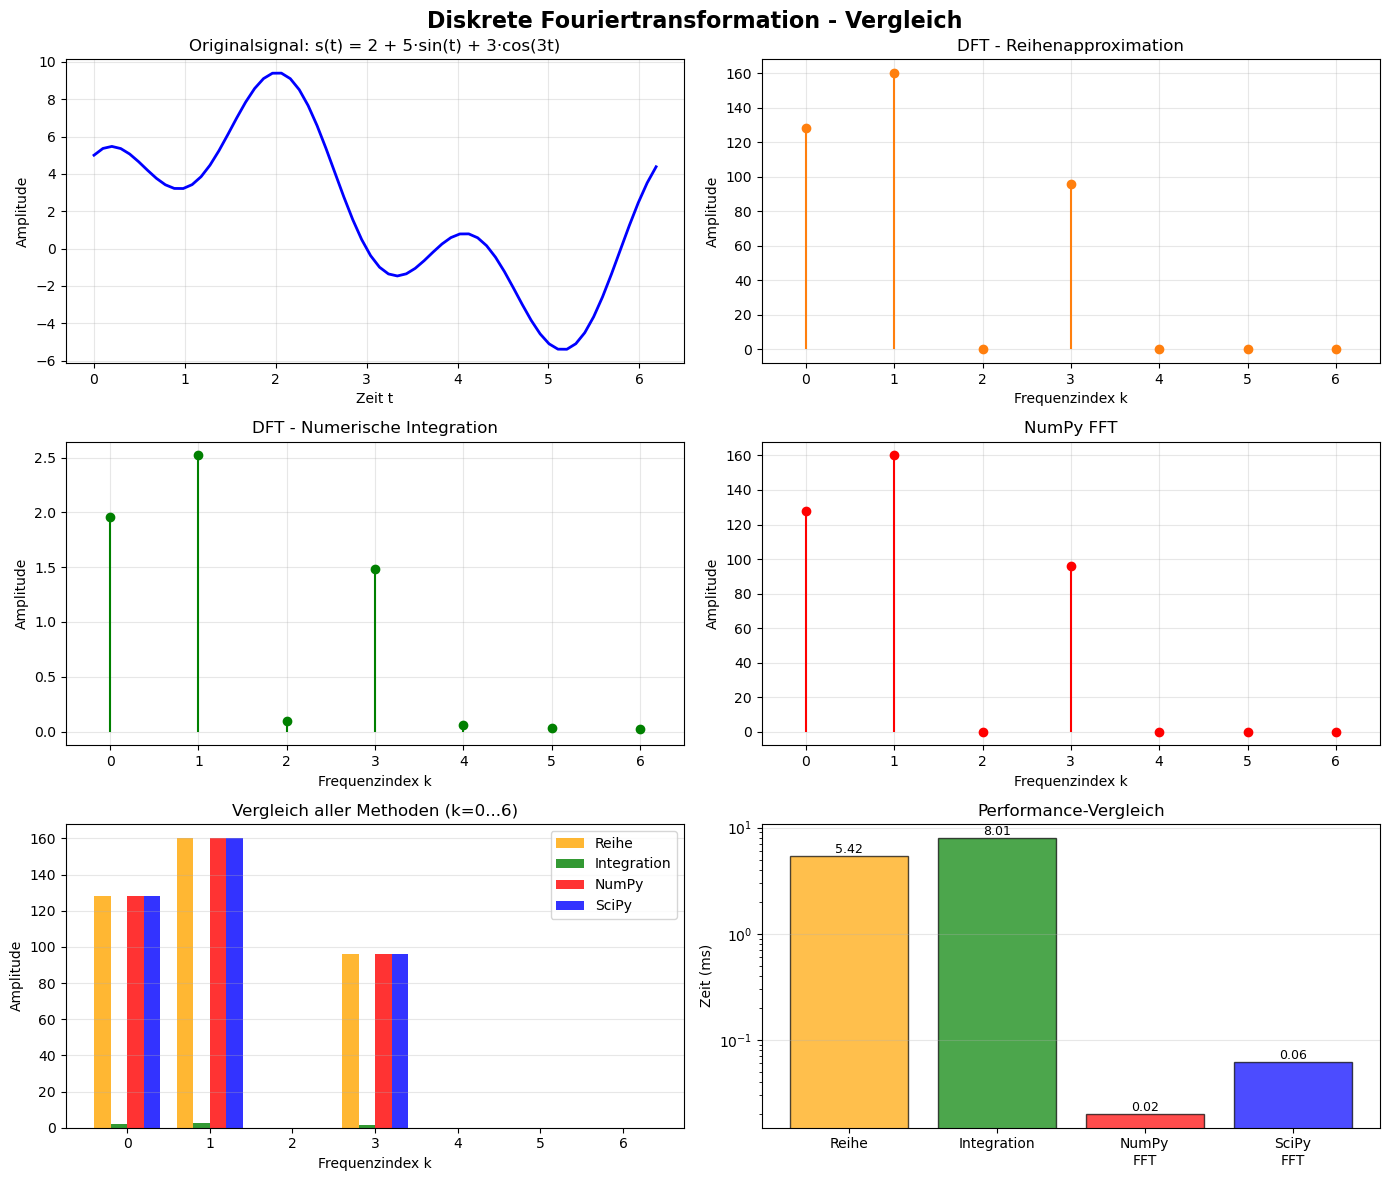

In [2]:
#DFT mittels Reihenapproximation
def dft_reihe(signal):
    N = len(signal)
    X = np.zeros(N, dtype=complex)

    for k in range(N):
        for n in range(N):
            X[k] += signal[n] * np.exp((-2j * np.pi * k * n) / N)
    return X

#DFT mittels numerischer Integration
def dft_integration(t, signal, n_freqs=None):
    if n_freqs is None:
        n_freqs = len(signal)

    T = t[-1] - t[0]
    omega = 2 * np.pi / T

    X = np.zeros(n_freqs, dtype=complex)

    for k in range(n_freqs):
        # a_k Kosinus-Koeffizient
        cos_integrand = signal * np.cos(k * omega * t)
        a_k = (2/T) * simpson(cos_integrand, x=t)

        # b_k Sinus-Koeffizient
        sin_integrand = signal * np.sin(k * omega * t)
        b_k = (2/T) * simpson(sin_integrand, x=t)

        # Konvertierung zu komplexer Form
        if k == 0:
            X[k] = a_k / 2  # DC-Komponente
        else:
            X[k] = (a_k - 1j * b_k) / 2

    return X

def generate_signal(t):
    return 2 + 5*np.sin(t) + 3*np.cos(3*t)

def compute_amplitude_spectrum(X):
    return np.abs(X)

def measure_performance(func, *args, runs=5):
    times = []
    for _ in range(runs):
        start = time.perf_counter()
        func(*args)
        end = time.perf_counter()
        times.append(end - start)
    return np.mean(times), np.std(times)

#Parameter
N = 64
t = np.linspace(0, 2*np.pi, N, endpoint=False)
signal = generate_signal(t)

print("Diskrete Fouriertransformation - Vergleich der Implementierungen")
print(f"Signal: s(t) = 2 + 5*sin(t) + 3*cos(3*t)")
print(f"Zeitintervall: [0, 2π]")
print(f"Anzahl Messwerte: {N}")

# DFT Berechnungen
print("\n1. DFT mittels Reihenapproximation...")
time_reihe, std_reihe = measure_performance(dft_reihe, signal)
X_reihe = dft_reihe(signal)
amp_reihe = compute_amplitude_spectrum(X_reihe)

print("\n2. DFT mittels numerischer Integration...")
time_int, std_int = measure_performance(dft_integration, t, signal, N)
X_int = dft_integration(t, signal, N)
amp_int = compute_amplitude_spectrum(X_int)

print("\n3. NumPy FFT...")
time_numpy, std_numpy = measure_performance(np.fft.fft, signal)
X_numpy = np.fft.fft(signal)
amp_numpy = compute_amplitude_spectrum(X_numpy)

print("\n4. SciPy FFT...")
time_scipy, std_scipy = measure_performance(fft, signal)
X_scipy = fft(signal)
amp_scipy = compute_amplitude_spectrum(X_scipy)

#Performance-Vergleich
print("PERFORMANCE-VERGLEICH (Mittelwert über 5 Durchläufe)")
print(f"{'Methode':<30} {'Zeit (ms)':<15} {'Std (ms)':<15} {'Faktor'}")
print(f"{'Reihenapproximation':<30} {time_reihe*1000:>10.4f} {std_reihe*1000:>10.4f}     {time_reihe/time_numpy:>8.1f}x")
print(f"{'Numerische Integration':<30} {time_int*1000:>10.4f} {std_int*1000:>10.4f}     {time_int/time_numpy:>8.1f}x")
print(f"{'NumPy FFT':<30} {time_numpy*1000:>10.4f} {std_numpy*1000:>10.4f}     {1.0:>8.1f}x")
print(f"{'SciPy FFT':<30} {time_scipy*1000:>10.4f} {std_scipy*1000:>10.4f}     {time_scipy/time_numpy:>8.1f}x")

#Genauigkeitsvergleich
print("GENAUIGKEITSVERGLEICH (Relativer Fehler zu NumPy FFT)")
error_reihe = np.mean(np.abs(X_reihe - X_numpy)) / np.mean(np.abs(X_numpy))
error_int = np.mean(np.abs(X_int - X_numpy[:N])) / np.mean(np.abs(X_numpy))
error_scipy = np.mean(np.abs(X_scipy - X_numpy)) / np.mean(np.abs(X_numpy))

print(f"{'Methode':<30} {'Mittlerer rel. Fehler'}")
print(f"{'Reihenapproximation':<30} {error_reihe:.2e}")
print(f"{'Numerische Integration':<30} {error_int:.2e}")
print(f"{'SciPy FFT':<30} {error_scipy:.2e}")

#Frequenzindizes für die Hauptkomponenten
freqs = np.fft.fftfreq(N, d=(2*np.pi/N))

print(f"\nAmplidenzwerte bei Frequenzindexe")
print(f"\n{'k':<12} {'Reihe':<12} {'Integration':<12} {'NumPy':<12}")
for k in [0, 1, 2, 3, 4, 5, 6]:
    print(f"{k:<12} {amp_reihe[k]:<12.4f} {amp_int[k]:<12.4f} {amp_numpy[k]:<12.4f}")

#Visualisierung
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Diskrete Fouriertransformation - Vergleich', fontsize=16, fontweight='bold')

# Original Signal
axes[0, 0].plot(t, signal, 'b-', linewidth=2)
axes[0, 0].set_xlabel('Zeit t')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].set_title('Originalsignal: s(t) = 2 + 5·sin(t) + 3·cos(3t)')
axes[0, 0].grid(True, alpha=0.3)

#Frequenzachse
freq_axis = np.arange(N)

#Reihenapproximation
axes[0, 1].stem(freq_axis[:N//2], amp_reihe[:N//2], basefmt=' ', linefmt='C1-', markerfmt='C1')
axes[0, 1].set_xlabel('Frequenzindex k')
axes[0, 1].set_ylabel('Amplitude')
axes[0, 1].set_title('DFT - Reihenapproximation')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(-0.5, 6.5)

#Numerische Integration
axes[1, 0].stem(freq_axis[:N//2], amp_int[:N//2], basefmt=' ', linefmt='g-', markerfmt='go')
axes[1, 0].set_xlabel('Frequenzindex k')
axes[1, 0].set_ylabel('Amplitude')
axes[1, 0].set_title('DFT - Numerische Integration')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim(-0.5, 6.5)

#NumPy FFT
axes[1, 1].stem(freq_axis[:N//2], amp_numpy[:N//2], basefmt=' ', linefmt='r-', markerfmt='ro')
axes[1, 1].set_xlabel('Frequenzindex k')
axes[1, 1].set_ylabel('Amplitude')
axes[1, 1].set_title('NumPy FFT')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim(-0.5, 6.5)

#Vergleich der ersten 7 Frequenzen
x_comp = np.arange(7)
width = 0.2
axes[2, 0].bar(x_comp - 1.5*width, amp_reihe[:7], width, label='Reihe', alpha=0.8, color='orange')
axes[2, 0].bar(x_comp - 0.5*width, amp_int[:7], width, label='Integration', alpha=0.8, color='g')
axes[2, 0].bar(x_comp + 0.5*width, amp_numpy[:7], width, label='NumPy', alpha=0.8, color='r')
axes[2, 0].bar(x_comp + 1.5*width, amp_scipy[:7], width, label='SciPy', alpha=0.8, color='b')
axes[2, 0].set_xlabel('Frequenzindex k')
axes[2, 0].set_ylabel('Amplitude')
axes[2, 0].set_title('Vergleich aller Methoden (k=0...6)')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3, axis='y')

#Performance-Vergleich
methods = ['Reihe', 'Integration', 'NumPy\nFFT', 'SciPy\nFFT']
times = [time_reihe*1000, time_int*1000, time_numpy*1000, time_scipy*1000]
colors = ['orange', 'g', 'r', 'b']
bars = axes[2, 1].bar(methods, times, color=colors, alpha=0.7, edgecolor='black')
axes[2, 1].set_ylabel('Zeit (ms)')
axes[2, 1].set_title('Performance-Vergleich')
axes[2, 1].set_yscale('log')
axes[2, 1].grid(True, alpha=0.3, axis='y')

#Balkendiagram
for bar, time_val in zip(bars, times):
    height = bar.get_height()
    axes[2, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{time_val:.2f}',
                   ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

Es ist ersichtlich, dass die Genauigkeit der numerischen Integration grundsätzlich nicht schlecht ist. Im Vergleich zur Reihenapproximation und zur FFT von SciPy schneidet sie jedoch deutlich am schlechtesten ab. Insbesondere zeigt sich bei der Genauigkeit ein erheblicher Unterschied: Während die numerische Integration einen sehr grossen relativen Fehler aufweist, liefern sowohl die Reihenapproximation als auch die SciPy-FFT Ergebnisse mit sehr hoher Genauigkeit.

Zwischen der Reihenapproximation und der SciPy-FFT ist der Genauigkeitsunterschied hingegen vernachlässigbar. Die zeitliche Differenz zwischen diesen beiden Methoden ist jedoch sehr gross. Die FFT ist im Mittel mehrere Millisekunden schneller, was sie insbesondere bei grösseren Programmen oder häufigen Berechnungen deutlich effizienter macht.

Aufgrund der hohen Genauigkeit bei gleichzeitig sehr kurzer Laufzeit würde ich daher in grösseren Anwendungen die FFT von SciPy bevorzugen (hohe Genauigkeit, sehr schnelle Transformation).

## Aufgabe 2

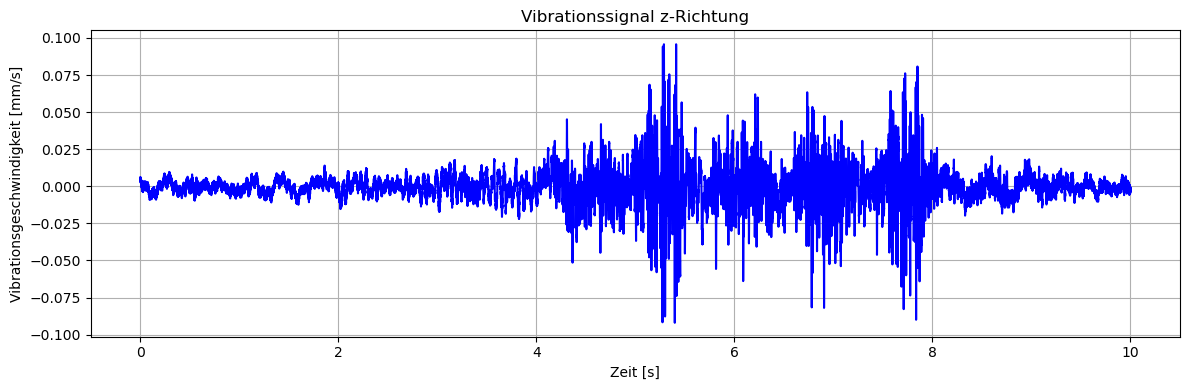

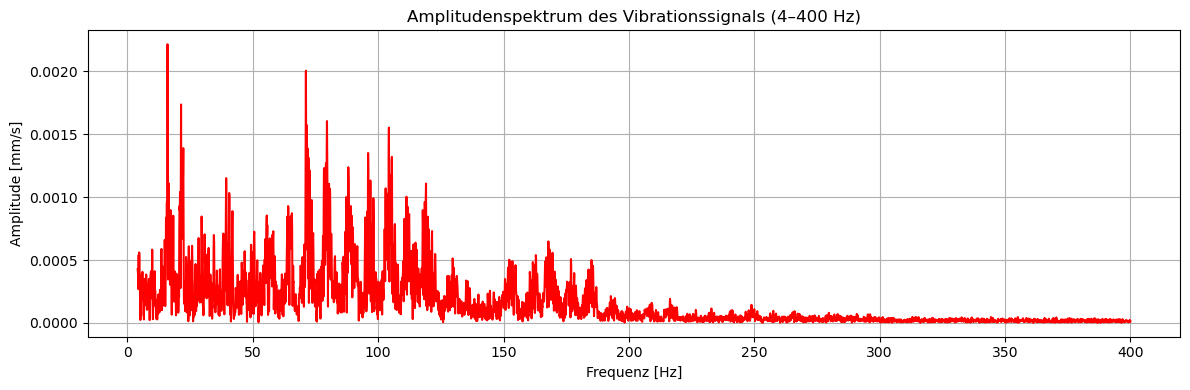

Die zwei dominantesten Frequenzen [Hz]: [15.9998648  71.19939837]
Geschätzter Schwellenabstand anhand der ersten Frequenz: 0.868 m
Geschätzter Schwellenabstand anhand der zweiten Frequenz: 0.195 m


In [12]:
tram_df = pd.read_csv("Data/tramdaten_fourier_vta_mc2_hs25.csv", sep=';')
t = tram_df["Zeit"].values
v_z = tram_df["Messwert"].values
N = len(v_z)

#Signal grafisch darstellen
plt.figure(figsize=(12,4))
plt.plot(t, v_z, 'b')
plt.xlabel('Zeit [s]')
plt.ylabel('Vibrationsgeschwindigkeit [mm/s]')
plt.title('Vibrationssignal z-Richtung')
plt.grid(True)
plt.tight_layout()
plt.show()

#Amplitudenspektrum berechnen
dt = t[1] - t[0] # Abtastintervall
fs = 1/dt # Abtastfrequenz

V_z_fft = fft(v_z)
freqs = fftfreq(N, dt)

# Nur positive Frequenzen
mask = freqs > 0
freqs_pos = freqs[mask]
amp_pos = (2/N) * np.abs(V_z_fft[mask])

# Frequenzbereich 4–400 Hz
freq_mask = (freqs_pos >= 4) & (freqs_pos <= 400)
freqs_plot = freqs_pos[freq_mask]
amp_plot = amp_pos[freq_mask]

#Amplitudenspektrum plotten
plt.figure(figsize=(12,4))
plt.plot(freqs_plot, amp_plot, 'r')
plt.xlabel('Frequenz [Hz]')
plt.ylabel('Amplitude [mm/s]')
plt.title('Amplitudenspektrum des Vibrationssignals (4–400 Hz)')
plt.grid(True)
plt.tight_layout()
plt.show()

#Dominante Frequenzen ermitteln
idx_sorted = np.argsort(amp_plot)[::-1]
dominant_freqs = freqs_plot[idx_sorted[:2]]
print("Die zwei dominantesten Frequenzen [Hz]:", dominant_freqs)

#Schwellenabstand abschätzen
v_kmh = 50
v_ms = v_kmh * 1000 / 3600 # 50 km/h in m/s

d1 = v_ms / dominant_freqs[0]
d2 = v_ms / dominant_freqs[1]

print(f"Geschätzter Schwellenabstand anhand der ersten Frequenz: {d1:.3f} m")
print(f"Geschätzter Schwellenabstand anhand der zweiten Frequenz: {d2:.3f} m")

## Aufgabe 3

In [4]:
def compute_fft_2d(func, x_min=-2, x_max=2, y_min=-2, y_max=2, N=64):
    x = np.linspace(x_min, x_max, N)
    y = np.linspace(y_min, y_max, N)
    X, Y = np.meshgrid(x, y)

    f = func(X, Y)

    F = np.fft.fft2(f)
    F_shift = np.fft.fftshift(F)
    amplitude = np.abs(F_shift)

    return X, Y, f, amplitude

def plot_fft_2d(X, Y, f, amplitude):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(f, extent=[X.min(), X.max(), Y.min(), Y.max()], cmap="gray")
    plt.title("Funktion f(x,y) (1=schwarz, 0=grau)")
    plt.xlabel("x")
    plt.ylabel("y")

    plt.subplot(1, 2, 2)
    plt.imshow(amplitude, cmap="inferno")
    plt.title("Amplitudenspektrum |FFT|")
    plt.colorbar(label="Amplitude")

    plt.tight_layout()
    plt.show()


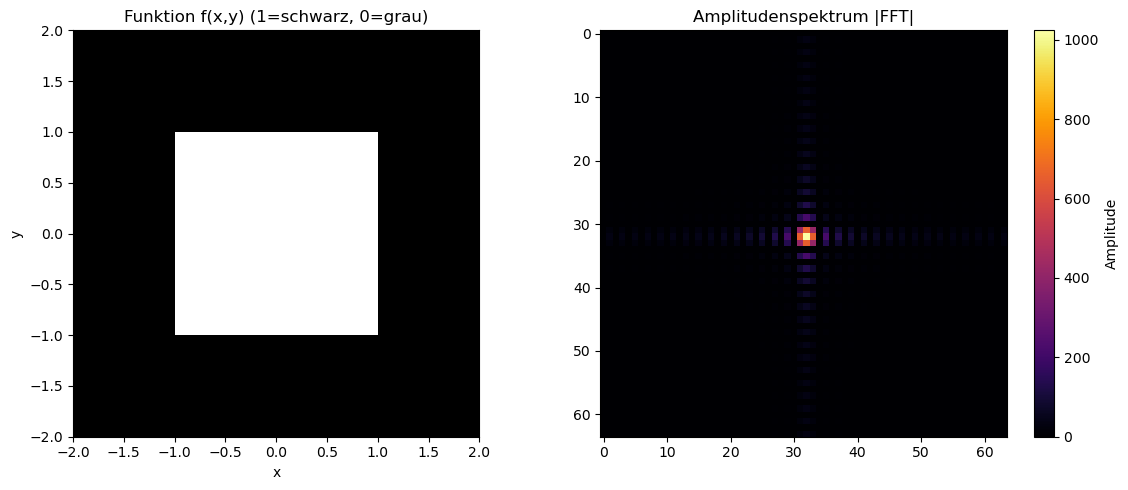

In [5]:
X, Y, f, amp = compute_fft_2d(lambda X, Y: (np.abs(X) <= 1) & (np.abs(Y) <= 1))
plot_fft_2d(X, Y, f, amp)

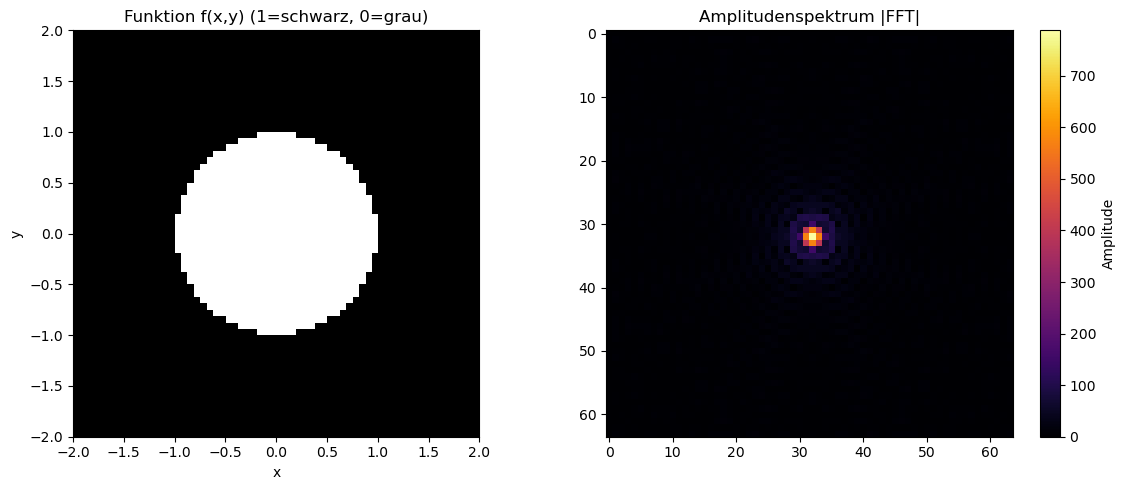

In [6]:
X, Y, f, amp = compute_fft_2d(lambda X, Y: (np.sqrt(X**2+Y**2)<=1))
plot_fft_2d(X, Y, f, amp)

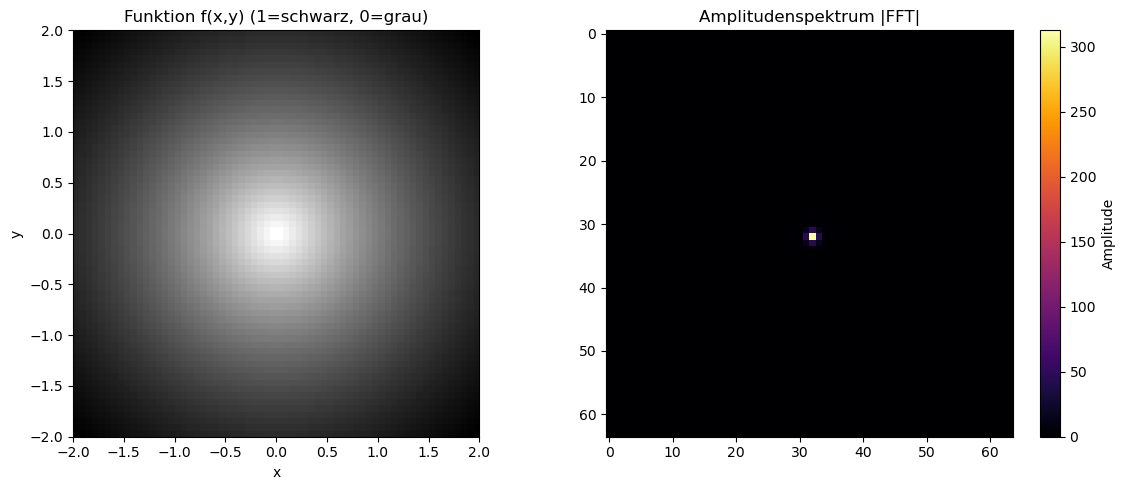

In [7]:
X, Y, f, amp = compute_fft_2d(lambda X, Y: (1/(2*np.pi)*np.exp(-(np.sqrt(X**2+Y**2)/2))))
plot_fft_2d(X, Y, f, amp)

## Aufgabe 4

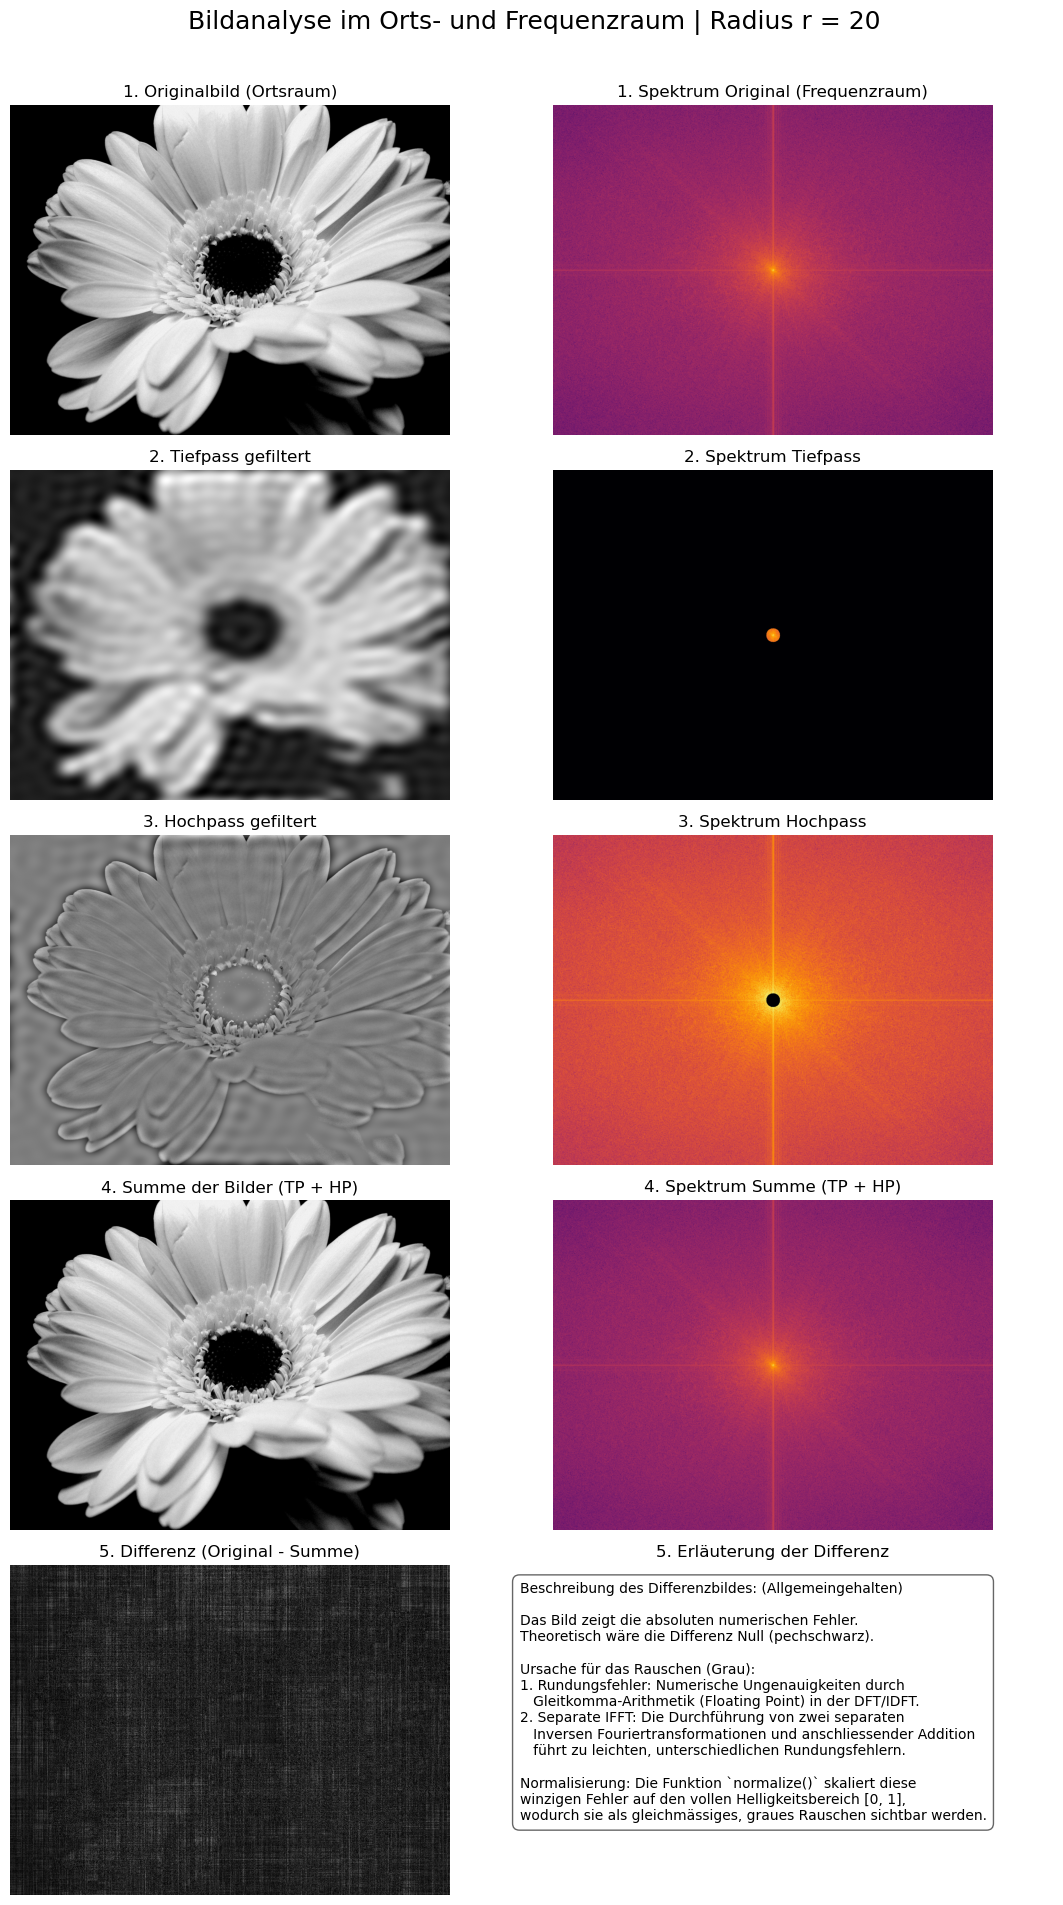

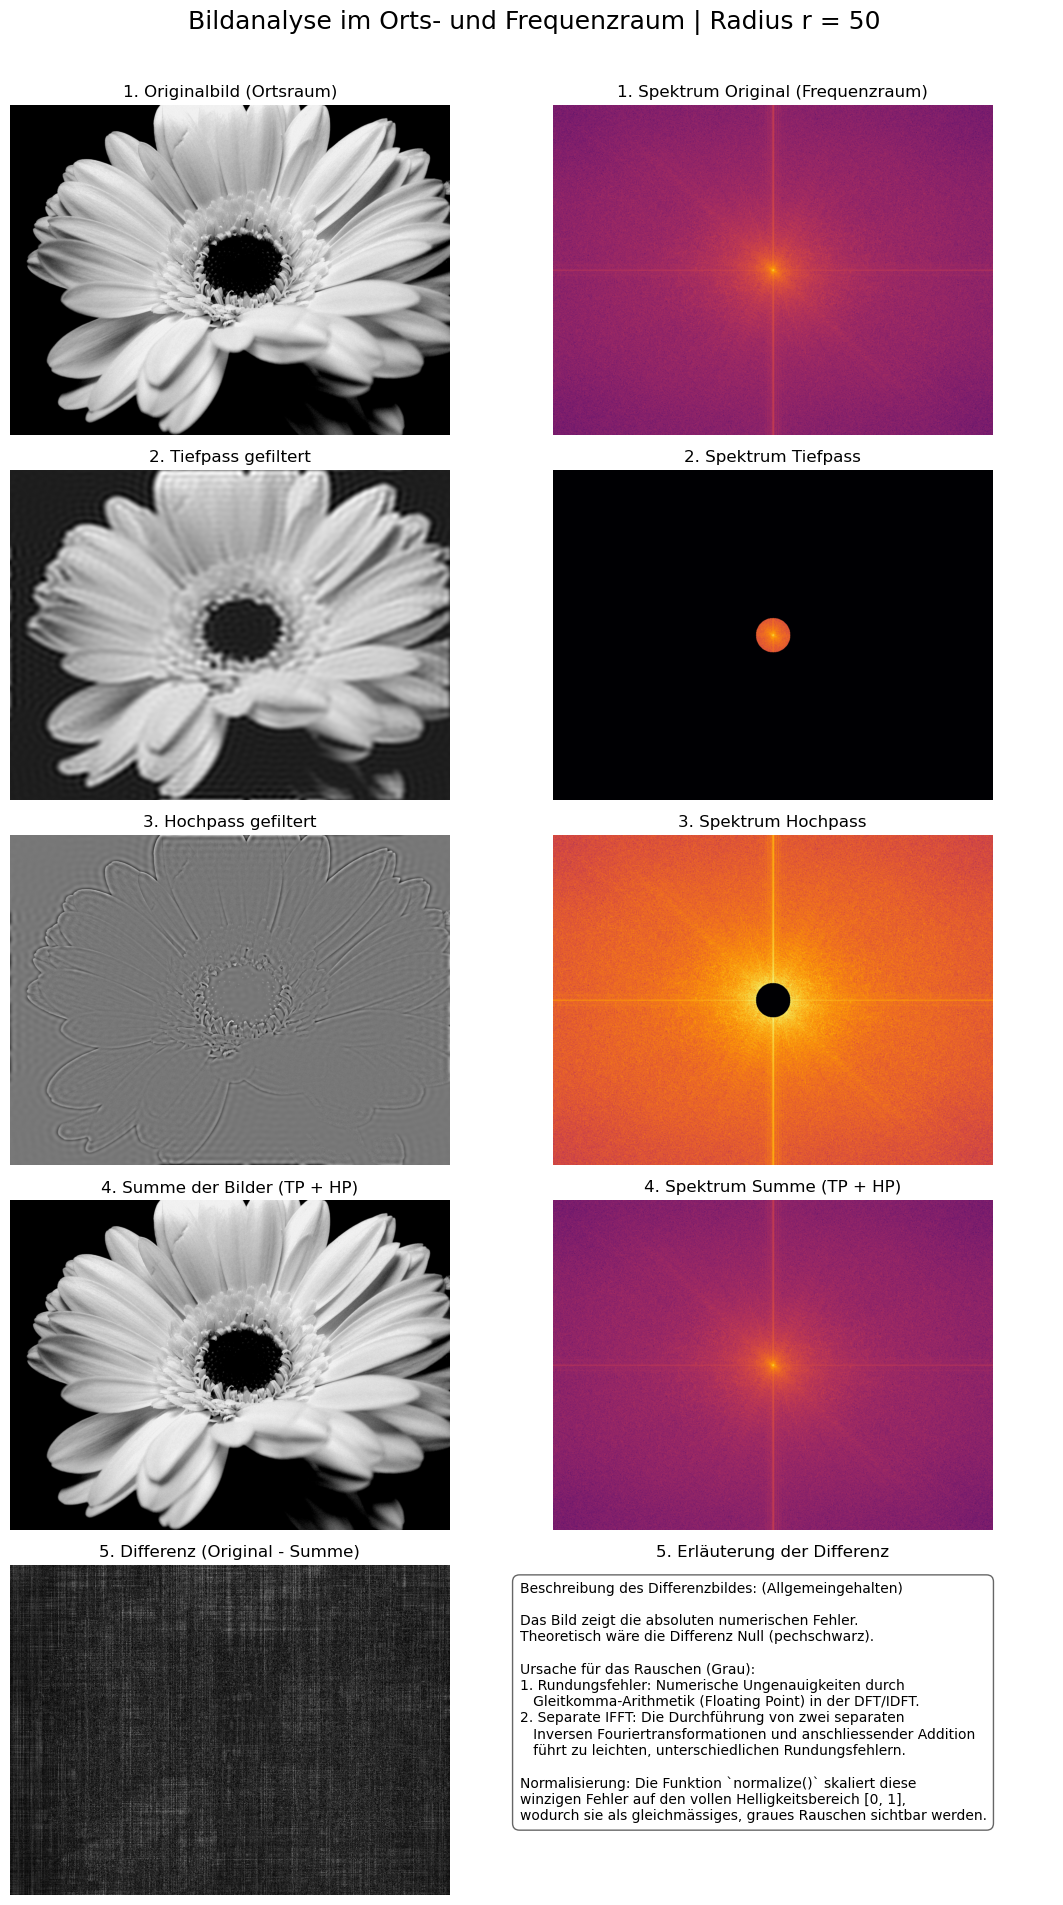

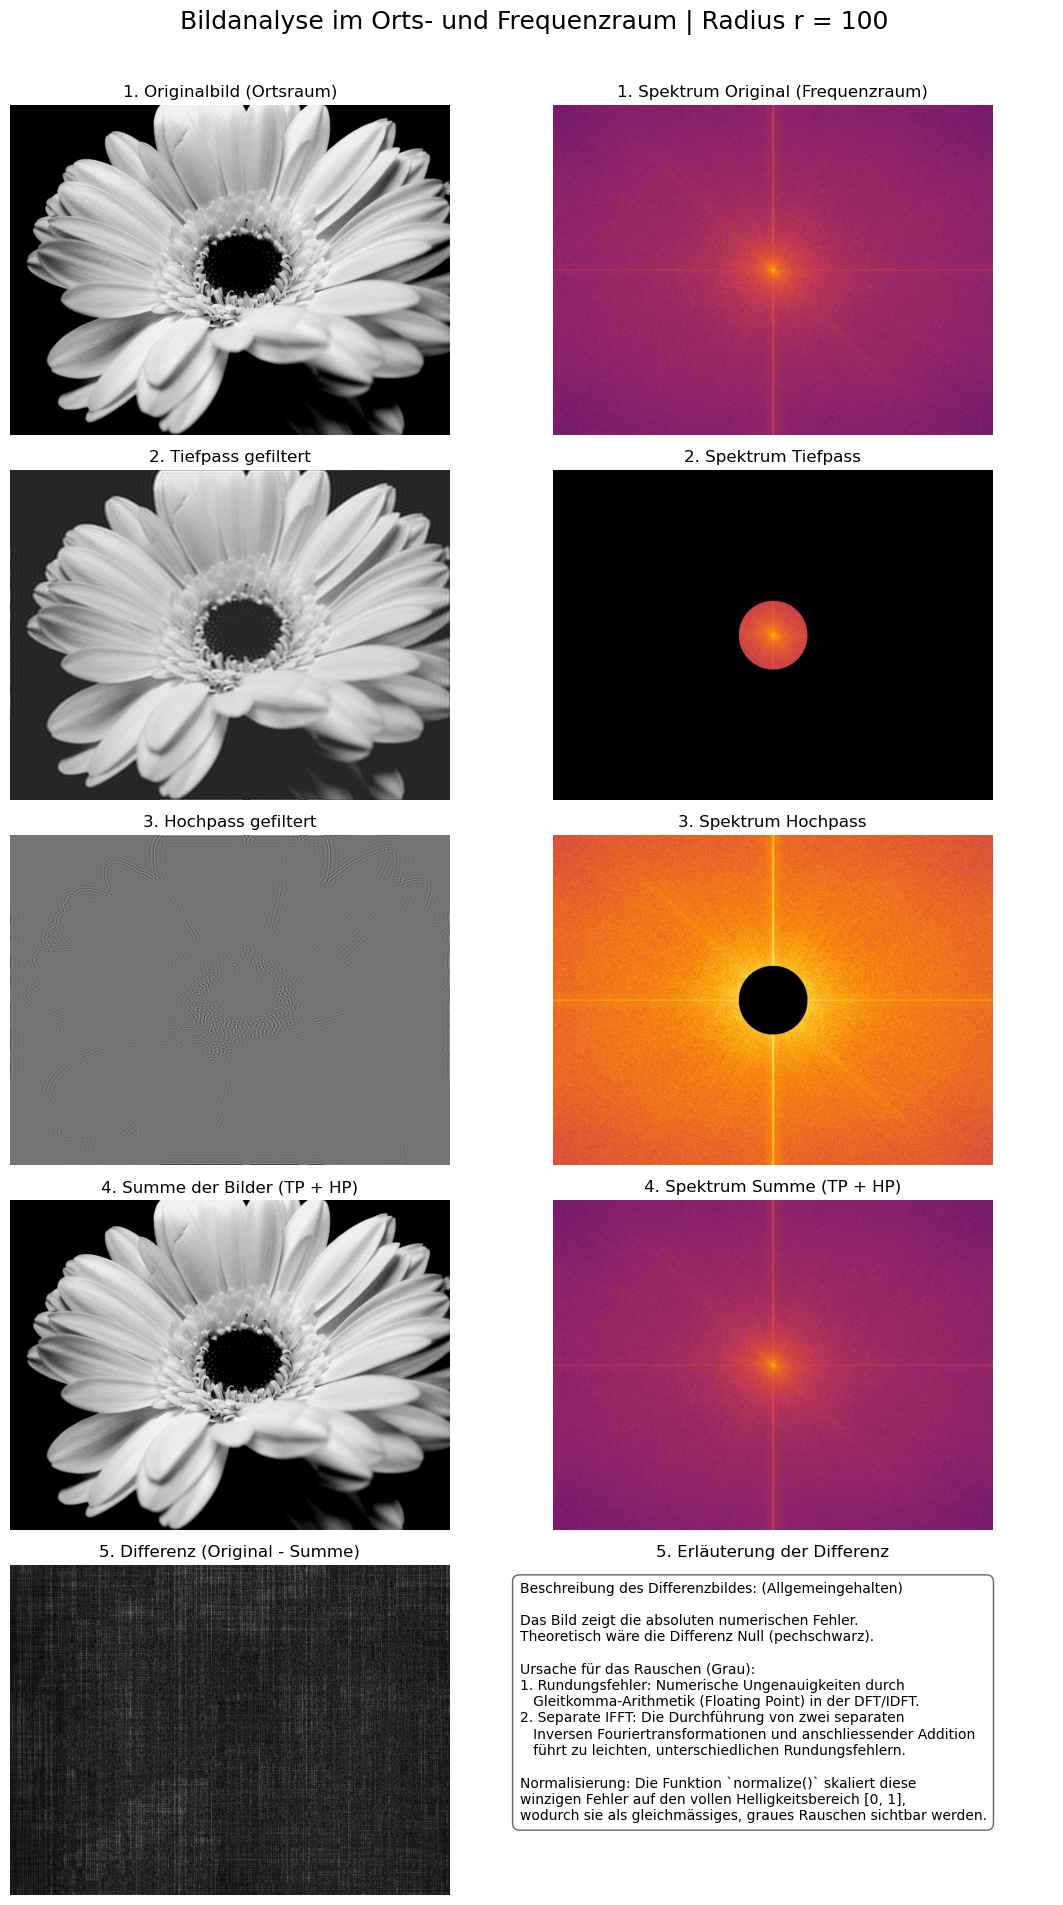

In [8]:
#Normalisierung auf [0,1]
def normalize(img):
    img = img.astype(float) 
    
    # Sicherstellen, dass kein leeres Array übergeben wird
    if np.max(img) == np.min(img):
        return np.zeros_like(img)
        
    img_norm = img - np.min(img)
    img_norm = img_norm / np.max(img_norm)
    return img_norm

#Bild laden
try:
    img = imageio.v2.imread("Data/img_a2_mc2_vta_hs25.bmp")
except FileNotFoundError:
    print("Die Datei wurde nicht gefunden. Verwende ein Platzhalterbild.")
    img = np.zeros((128, 128), dtype=np.uint8)
    img[32:96, 32:96] = 255
    
if img.ndim == 3:
    img = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140]).astype(img.dtype)

#2D-Fourier-Transformation
F = np.fft.fft2(img)
F_shifted = np.fft.fftshift(F)

magnitude_spectrum = np.log(1 + np.abs(F_shifted))

#Filter
rows, cols = img.shape
crow, ccol = rows//2, cols//2

radii = [20, 50, 100]

# Text für die Beschreibung des Differenzbildes. Dieser Text wurde nach mehreren Testläufen hier eingetragen
difference_description = (
    "Beschreibung des Differenzbildes: (Allgemeingehalten)\n\n"
    "Das Bild zeigt die absoluten numerischen Fehler.\n"
    "Theoretisch wäre die Differenz Null (pechschwarz).\n"
    "\n"
    "Ursache für das Rauschen (Grau):\n"
    "1. Rundungsfehler: Numerische Ungenauigkeiten durch\n"
    "   Gleitkomma-Arithmetik (Floating Point) in der DFT/IDFT.\n"
    "2. Separate IFFT: Die Durchführung von zwei separaten\n"
    "   Inversen Fouriertransformationen und anschliessender Addition\n"
    "   führt zu leichten, unterschiedlichen Rundungsfehlern.\n"
    "\n"
    "Normalisierung: Die Funktion `normalize()` skaliert diese\n"
    "winzigen Fehler auf den vollen Helligkeitsbereich [0, 1],\n"
    "wodurch sie als gleichmässiges, graues Rauschen sichtbar werden."
)

for r in radii:
    # Tiefpassfilter
    low_pass = np.zeros((rows, cols))
    y, x = np.ogrid[:rows, :cols]
    mask = (x - ccol)**2 + (y - crow)**2 <= r**2
    low_pass[mask] = 1

    # Hochpassfilter
    high_pass = 1 - low_pass

    # Filter auf Fourier-Daten anwenden
    F_low = F_shifted * low_pass
    F_high = F_shifted * high_pass

    # Inverse Fourier-Transformation
    img_low = np.fft.ifft2(np.fft.ifftshift(F_low)).real
    img_high = np.fft.ifft2(np.fft.ifftshift(F_high)).real

    img_low_high = img_low + img_high

    # Die Differenz berechnen
    difference_img = np.abs(img - img_low_high)

    # Betragsspektrum nach Filterung
    spectrum_low = np.log(1 + np.abs(F_low))
    spectrum_high = np.log(1 + np.abs(F_high))

    #5 Zeilen, 2 Spalten (5x2 Layout)
    plt.figure(figsize=(12, 20)) # Figurgrösse für Hochformat und gute Sichtbarkeit angepasst
    plt.suptitle(f"Bildanalyse im Orts- und Frequenzraum | Radius r = {r}", fontsize=18)

    # 1. Zeile
    # Originalbild (links)
    plt.subplot(5, 2, 1)
    plt.imshow(normalize(img), cmap='gray')
    plt.title("1. Originalbild (Ortsraum)")
    plt.axis('off')
    
    # Spektrum Original (rechts)
    plt.subplot(5, 2, 2)
    plt.imshow(normalize(magnitude_spectrum), cmap='inferno')
    plt.title("1. Spektrum Original (Frequenzraum)")
    plt.axis('off')

    # 2. Zeile
    # Tiefpassbild (links)
    plt.subplot(5, 2, 3)
    plt.imshow(normalize(img_low), cmap='gray')
    plt.title("2. Tiefpass gefiltert")
    plt.axis('off')
    
    # Tiefpass-Spektrum (rechts)
    plt.subplot(5, 2, 4)
    plt.imshow(normalize(spectrum_low), cmap='inferno')
    plt.title("2. Spektrum Tiefpass")
    plt.axis('off')

    # 3. Zeile
    # Hochpassbild (links)
    plt.subplot(5, 2, 5)
    plt.imshow(normalize(img_high), cmap='gray')
    plt.title("3. Hochpass gefiltert")
    plt.axis('off')
    
    # Hochpass-Spektrum (rechts)
    plt.subplot(5, 2, 6)
    plt.imshow(normalize(spectrum_high), cmap='inferno')
    plt.title("3. Spektrum Hochpass")
    plt.axis('off')
    
    # 4. Zeile
    # Tiefpassbild + Hochpassbild (links)
    plt.subplot(5, 2, 7)
    plt.imshow(normalize(img_low_high), cmap='gray')
    plt.title("4. Summe der Bilder (TP + HP)")
    plt.axis('off')

    # Summe der Spektren (rechts, entspricht Originalspektrum)
    plt.subplot(5, 2, 8)
    plt.imshow(normalize(magnitude_spectrum), cmap='inferno')
    plt.title("4. Spektrum Summe (TP + HP)")
    plt.axis('off')

    # 5. Zeile
    # Differenzbild (links)
    plt.subplot(5, 2, 9)
    plt.imshow(normalize(difference_img), cmap='gray')
    plt.title("5. Differenz (Original - Summe)")
    plt.axis('off')

    # Erklärung als Text-Box (rechts)
    plt.subplot(5, 2, 10)
    plt.text(0.05, 0.95, difference_description, 
             transform=plt.gca().transAxes, 
             fontsize=10, 
             verticalalignment='top', 
             bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.6))
    plt.title("5. Erläuterung der Differenz", fontsize=12)
    plt.axis('off')


    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # rect für besseren Platz des Titels
    plt.show()

## Einfluss des Radius auf die einzelnen Bilder
Bei einem kleinen Radius (z.B. $r=20$) filtert der Tiefpass fast alle Frequenzen heraus und lässt nur die sehr niedrigen (den Durchschnittswert und langsame Helligkeitsübergänge) passieren. Das resultierende Tiefpassbild ist daher extrem unscharf und verschwommen. Im komplementären Hochpassbild hingegen werden fast alle hohen und mittleren Frequenzen beibehalten, da nur der kleine zentrale Bereich blockiert wird. Dieses Bild enthält somit die meisten Kanten und Details und sieht dem Original bereits relativ ähnlich (es fehlt lediglich der allgemeine Grauwert).

Bei einem grossen Radius (z.B. $r=100$) kehrt sich dieses Verhältnis weitgehend um. Das Tiefpassbild enthält nun fast alle Frequenzen des Originals und sieht diesem sehr ähnlich, da nur die allerfeinsten Details fehlen. Das Hochpassbild hingegen lässt nur die höchsten Frequenzen (feinste Kanten und Rauschen) passieren und erscheint daher sehr dunkel und kontrastarm.